In [1]:
import init

from analisys.bkt_analisys import *
from analisys.data_analisys import *
from analisys.graph_analisys import *
from analisys.optmizer_analisys import *


import pandas as pd
import seaborn as sns
sns.set_theme()

import random
import os

from backend.resampler import *
from backend.mt5_tools import *

from statsmodels.tsa.stattools import adfuller
from analisys.graph_analisys import moving_avg
from secrets import token_hex as token


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.orca.config.use_xvfb = True

In [2]:
#definindo parametros

start_date = '2022.01.09'
end_date = '2022.02.20'


param = 'roiloss'
csv_l = 'symbols_ibovf.csv'
opt = 'forest'


timeframe = 5 # timeframe = 5 minutos
sample_size = 10 # quantidade de pares sendo negociados simultaneamente
n_opt = 25 # parametro do optmizer
lags = 22 # parametro do 'teste de cointegracao'
p_size = 10000 # tamanho da posicao

d_train = 30 # numero de dias sendo 'treinados'.
d_test = 5 # numero de dias sendo 'testados'.


ibov = pd.DataFrame(mt5_singlehistoricaldata('IBOV', 16408, start_date, end_date, forex=False, SERVER='tcp://192.168.100.106:10000')).iloc[::-1]

period = [10,100]
stop_n = [25,50]
stop_r = [-300, 0]
s_spread = [0, 5]
l_spread = [-5, 0]
tp_s =[-1, 0]
tp_l =[0, 1]
tp_r =[700, 3000] #700,3000
c_min=[50, 250]


'''  
period = [10,250]
stop_n = [25,50]
stop_r = [-300, 0]
s_spread = [0, 5]
l_spread = [-5, 0]
tp_s =[-1, 0]
tp_l =[0, 1]
tp_r =[700, 3000] #700,3000
c_min=[50, 250]
'''


plt.plot(ibov['close'])

space_param = [(period[0], period[1]),
                (s_spread[0], s_spread[1]),
                (l_spread[0], l_spread[1]),
                (tp_s[0], tp_s[1]),
                (tp_l[0], tp_l[1]),
                (tp_r[0], tp_r[1]),
                (stop_n[0], stop_n[1]),
                (stop_r[0], stop_r[1]),
                (c_min[0], c_min[1])]


In [3]:
def get_days(start_date, end_date, d_train, d_test):

    ibov = mt5_singlehistoricaldata('IBOV', 16408, start_date, end_date, SERVER='tcp://192.168.100.106:10000')
    ibov_date = list(ibov['date'])
    ibov_date.reverse()

    date_iteration = []

    for d in range(len(ibov_date))[:-(d_train+d_test)]:

        train_startdate = ibov_date[d].split(' ')[0]
        train_enddate = ibov_date[d+d_train].split(' ')[0]
        test_startdate = ibov_date[d+d_train].split(' ')[0]
        test_enddate = ibov_date[d+d_test+d_train].split(' ')[0]

        date_iteration.append(tuple([train_startdate, train_enddate,
                                    test_startdate, test_enddate]))

    #real_startdate = date_iteration[0][2]
    #real_enddate = date_iteration[-1][-2]

    return date_iteration, ibov_date

def cointpair_selection(hist, dataframe, lags):

    co = h_coint(hist, dataframe, n_lags=lags)
    co = pd.DataFrame(co)
    co = co.sort_values(by=['pvalue'])
    co = co.reset_index(drop=True)

    new_co = pd.DataFrame({'pvalue':pd.Series([]), 'stdx':pd.Series([]), 
                                'stdy':pd.Series([]), 'x':pd.Series([]), 'y':pd.Series([])})


    if(len(co) == 0):
        return new_co

    co_len = [i for i in range(len(co))]

    for j in co_len:

        x,y = list(co['x'])[j], list(co['y'])[j]
        
        new_co = new_co.append(co.iloc()[j])
        new_co = new_co.reset_index(drop=True)
    
    new_co = new_co.reset_index(drop=True)
    '''   
        if not(
                    (x in list(new_co['x'])) or 
                    (x in list(new_co['y'])) 
        
                    or 
                    
                    (y in list(new_co['x'])) or 
                    (y in list(new_co['y']))):

            new_co = new_co.append(co.iloc()[j])

    new_co = new_co.reset_index(drop=True)
    '''


    return new_co

220 ['2021.02.22 00:00', '2021.02.23 00:00', '2021.02.24 00:00', '2021.02.25 00:00', '2021.02.26 00:00', '2021.03.01 00:00', '2021.03.02 00:00', '2021.03.03 00:00', '2021.03.04 00:00', '2021.03.05 00:00', '2021.03.08 00:00', '2021.03.09 00:00', '2021.03.10 00:00', '2021.03.11 00:00', '2021.03.12 00:00', '2021.03.15 00:00', '2021.03.16 00:00', '2021.03.17 00:00', '2021.03.18 00:00', '2021.03.19 00:00', '2021.03.22 00:00', '2021.03.23 00:00', '2021.03.24 00:00', '2021.03.25 00:00', '2021.03.26 00:00', '2021.03.29 00:00', '2021.03.30 00:00', '2021.03.31 00:00', '2021.04.01 00:00', '2021.04.05 00:00', '2021.04.06 00:00', '2021.04.07 00:00', '2021.04.08 00:00', '2021.04.09 00:00', '2021.04.12 00:00', '2021.04.13 00:00', '2021.04.14 00:00', '2021.04.15 00:00', '2021.04.16 00:00', '2021.04.19 00:00', '2021.04.20 00:00', '2021.04.22 00:00', '2021.04.23 00:00', '2021.04.26 00:00', '2021.04.27 00:00', '2021.04.28 00:00', '2021.04.29 00:00', '2021.04.30 00:00', '2021.05.03 00:00', '2021.05.04 00:

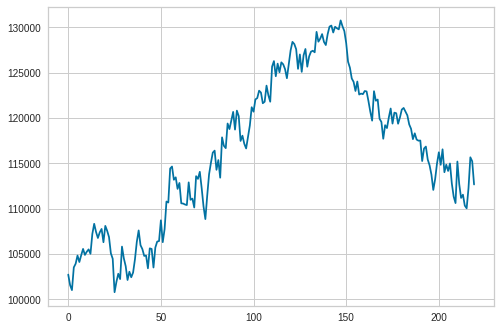

In [4]:
d = get_days(start_date, end_date, d_train, d_test)
len(d[1])
print(len(d[1]), d[1])
print(d[1][2])

hist = mt5_historicaldata(timeframe, start_date, end_date, csv_list = csv_l, interpol=False, bolsa='IBOV', SERVER='tcp://192.168.100.106:10000')


In [5]:
hist = mt5_historicaldata(timeframe, start_date, end_date, csv_list = csv_l, interpol=False, bolsa='IBOV', SERVER='tcp://192.168.100.105:10000')


FileNotFoundError: [Errno 2] No such file or directory: 'symbols_ibovf.csv'

In [ ]:
co_hist = cointpair_selection(hist, timeframe, lags)
co_hist

In [ ]:
sample_x = co_hist['x'], 
sample_y = co_hist['y']

sample = sample_x, sample_y

In [ ]:
name_x = 'MULT3'
name_y = 'B3SA3'
df_treino = hist
pos_size = 10000
opt_param = param


In [ ]:
n=5
forest = forest_minimize(treino, space_param, random_state=0, verbose=0, n_calls = n_opt)
a, b = results(forest, n)
a

In [ ]:
count = 0
for param in b:
    
    treino = simplebkt(df_treino[name_x], df_treino[name_y], name_x, name_y, param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], param[8], optimizer='dic')
    plt.plot(np.cumsum(treino['returns']), label=str('{}x  {}: {}'.format(str(count), a['stop'][count],sum(treino['returns']))))

    count+= 1

plt.legend()
plt.show()


num = 0
param_list = []
param_list.append(name_x)
param_list.append(name_y)
param_list.append(pos_size)


for i in b[num]:
    param_list.append(i)

print('fourteenbis_live',tuple(param_list),'|', s)

In [ ]:
start_date = '2022.02.20'
end_date = '2022.02.25'

s_spread = 0
l_spread = -1
tp_short = 0
tp_long = 1
tp_return = 1416
stop_return = -145
stop_number = 28
period = 41     #afeta
min_count = 115
p_size = 10000

hist_x = mt5_singlehistoricaldata(name_x,timeframe, start_date, end_date)
hist_y = mt5_singlehistoricaldata(name_y,timeframe, start_date, end_date)

hist_x.replace(0, np.NaN, inplace=True)
hist_x = hist_x.interpolate(method='linear', limit_direction='forward', axis=0)

hist_y.replace(0, np.NaN, inplace=True)
hist_y = hist_y.interpolate(method='linear', limit_direction='forward', axis=0)

In [ ]:
result = runbkt(hist_x, hist_y, name_x, name_y, period, s_spread, l_spread, tp_short, tp_long, stop_number, min_count ,p_size)
pos_info(result['positions_list'])


In [ ]:
positions_markers_buy = []
positions_markers_sell = []

for mark in result['positions_list']:

    if(mark['type'] == 'long_spread'):
        positions_markers_buy.append(mark['df_iteration'][1])
        positions_markers_sell.append(mark['df_iteration'][0])

    if(mark['type'] == 'short_spread'):
        positions_markers_buy.append(mark['df_iteration'][0])
        positions_markers_sell.append(mark['df_iteration'][1])

In [ ]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(18.5, 10.5)

axs[0].plot(result['spread'])
axs[0].set_title('spread')
axs[1].plot(result['price']['x_price'])
axs[1].set_title('x_price')
axs[2].plot(result['price']['y_price'])
axs[2].set_title('y_price')
fig.tight_layout()


In [ ]:
hist_x_open = np.array(hist_x['open'])
hist_x_close = np.array(hist_x['close'])
hist_y_open = np.array(hist_y['open'])
hist_y_close = np.array(hist_y['close'])

#print(hist_y_close)

for idx in np.where(hist_x_close == 0):
    try:
        hist_x_close[idx] = (hist_x_close[idx-1] + hist_x_close[idx+1])/2
    except:
        print('fail')

xs_axis = range(len(hist_x_open))

#short_spread => X_BUY, Y_SELL
#long_spread  => X_SELL, Y_BUY

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

result['positions_list']

#grarficos

for mark in result['positions_list']:
    
    if(mark['type'] == 'long_spread'):
        
        axs[0].plot(hist_x_close,color = 'gray', linestyle='--',  linewidth=1 ,marker='^', markersize=16, markerfacecolor='green', markevery=positions_markers_buy)
        axs[0].plot(hist_x_close, color = 'gray', linestyle='--',linewidth=1 , marker='v', markersize=16, markerfacecolor='red', markevery=positions_markers_sell)
        axs[0].set_xlabel('{}-{} {}'.format(result['info']['x_symbol'],result['positions_list'][result['positions_list'].index(mark)]['x_type'], result['positions_list'][result['positions_list'].index(mark)]['x_volume']))


        axs[1].plot(hist_y_close, color = 'gray', linestyle='--', linewidth=1 ,marker='v', markersize=16, markerfacecolor='red', markevery=positions_markers_buy)
        axs[1].plot(hist_y_close, color = 'gray', linestyle='--', linewidth=1 ,marker='^', markersize=16, markerfacecolor='green', markevery=positions_markers_sell)
        axs[1].set_xlabel('{}-{} {}'.format(result['info']['y_symbol'],result['positions_list'][result['positions_list'].index(mark)]['y_type'], result['positions_list'][result['positions_list'].index(mark)]['y_volume']))
        

    if(mark['type'] == 'short_spread'):

        axs[0].plot(hist_y_close, color = 'gray',linestyle='--',linewidth=1 , marker='v', markersize=16, markerfacecolor='red', markevery=positions_markers_buy)
        axs[0].plot(hist_y_close, color = 'gray', marker='^',linestyle='--',linewidth=1 , markersize=16, markerfacecolor='green', markevery=positions_markers_sell)
        axs[0].set_xlabel('{}-{} {}'.format(result['info']['y_symbol'],result['positions_list'][result['positions_list'].index(mark)]['y_type'], result['positions_list'][result['positions_list'].index(mark)]['y_volume']))
        
        axs[1].plot(hist_x_close, color = 'gray', marker='^',linestyle='--',linewidth=1 , markersize=16, markerfacecolor='green', markevery=positions_markers_buy)
        axs[1].plot(hist_x_close, color = 'gray', marker='v',linestyle='--',linewidth=1 , markersize=16, markerfacecolor='red', markevery=positions_markers_sell)
        axs[1].set_xlabel('{}-{} {}'.format(result['info']['x_symbol'],result['positions_list'][result['positions_list'].index(mark)]['x_type'], result['positions_list'][result['positions_list'].index(mark)]['x_volume']))




In [ ]:
#auxilia a tratar alguns dados

df_iteration = result['positions_list'][0]['df_iteration']

x_lprofit = []
y_lprofit = []
np_hist_x = np.array(hist_x_close)[df_iteration[0]:df_iteration[1]+1]
np_hist_y = np.array(hist_y_close)[df_iteration[0]:df_iteration[1]+1]

x_volume = result['positions_list'][0]['x_volume']
y_volume = result['positions_list'][0]['y_volume']


for i in range(len(np_hist_x)):
    x_lprofit.append(x_volume*np_hist_x[i])
    y_lprofit.append(y_volume*np_hist_y[i])

x_profit = 0
y_profit = 0

for r in range(len(result['positions_list'])):
    if(result['positions_list'][r]['type'] == 'short_spread'):
        x_profit += np.array(x_lprofit) - x_lprofit[0]
        y_profit += -np.array(y_lprofit) + y_lprofit[0]


    if(result['positions_list'][r]['type'] == 'long_spread'):
        x_profit += -np.array(x_lprofit) + x_lprofit[0]
        y_profit += np.array(y_lprofit) - y_lprofit[0]


s_profit = x_profit + y_profit

print(len(x_profit))

fig, axs = plt.subplots(1, 1)



axs.plot(x_profit, label='x_profit', linestyle='--', linewidth=0.7, color='blue')
axs.plot(y_profit, label='y_profit', linestyle='--', linewidth=0.7, color='red')
axs.plot(s_profit,label='sum_profit', linewidth=2, color = 'green')
axs.legend(loc='upper left')
axs.set_title('R${}'.format(result['profit']))

print(s_profit[-1])